### Analysis for "Rapid seaward expansion of seaport footprints worldwide" (Sengupta & Lazarus, 2023)
#### Revised: July 2023
#### This code uses (1) data for seaward seaport expansion between 1990–2020 (calculated separately, with Google Earth Engine: https://github.com/dhritirajsen/Mapping_Coastal_land_reclamation), and (2) reported trade volume compiled from Lloyd's List reports ranking the top 100 container ports in the world, to generate time series and other summary analysis. 

In [1]:
# Import libraries

import pandas as pd
from pandas.plotting import parallel_coordinates
import numpy as np
import math

# Import curve-fitting package from scipy
from scipy.optimize import curve_fit
from scipy import stats

import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Time series of seaward expansion, 1990–2020

In [2]:
# Import the reclamation area over time
RECTIME = pd.read_csv("Sengupta_Lazarus_REC_1990_2020_v02.csv")

RECTIME.head(3) # check to confirm

,Year,Seaport,Country,Region,"Reclaimed area (km^2, raw)","Reclaimed area (km^2, smoothed)"
0,1990,Abu Dhabi,UAE,Middle East,11.76,11.76
1,1990,Alexandria,Egypt,Middle East,0.44,0.44
2,1990,Algeciras,Spain,Mediterranean,0.62,0.62


In [3]:
# Sort the data by year, then by seaport (alphabetically)
RECTIME.sort_values(by=["Year", "Seaport"], inplace=True)
RECTIME.reset_index(drop=True)
RECTIME.head(3)

,Year,Seaport,Country,Region,"Reclaimed area (km^2, raw)","Reclaimed area (km^2, smoothed)"
0,1990,Abu Dhabi,UAE,Middle East,11.76,11.76
1,1990,Alexandria,Egypt,Middle East,0.44,0.44
2,1990,Algeciras,Spain,Mediterranean,0.62,0.62


In [4]:
# Number of seaports in each region
Rreg = RECTIME.groupby("Region")["Seaport"].nunique()
Rreg

Region
Africa                      2
Asia                       43
Central & South America     1
Mediterranean               6
Middle East                 8
North America               2
Northern Europe             3
Oceania                     1
Name: Seaport, dtype: int64

In [5]:
# Total of seaports in the dataset
Rreg = RECTIME.groupby("Region")["Seaport"].nunique().sum()
Rreg

66

In [6]:
# Number of seaports in each country
Rcountry = RECTIME.groupby("Country")["Seaport"].nunique()
Rcountry

Country
Australia        1
China           21
Colombia         1
Egypt            2
France           1
Greece           1
India            2
Indonesia        2
Italy            1
Japan            5
Malaysia         2
Mexico           1
Morocco          1
Netherlands      1
Oman             1
Pakistan         1
Philippines      1
Saudi Arabia     3
Singapore        1
South Africa     1
South Korea      3
Spain            3
Sri Lanka        1
Taiwan           2
Thailand         1
Togo             1
UAE              2
UK               1
USA              1
Vietnam          1
Name: Seaport, dtype: int64

In [7]:
# Add China as its own region (alternative region grouping)

RECTIME["Region (with China)"] = RECTIME["Region"]

RECTIME.loc[RECTIME['Country'] == 'China', 'Region (with China)'] = 'China'

# tidy up...
R2 = RECTIME.pop("Region (with China)")
RECTIME.insert(4, "Region (with China)", R2)

RECTIME.head(10)

,Year,Seaport,Country,Region,Region (with China),"Reclaimed area (km^2, raw)","Reclaimed area (km^2, smoothed)"
0,1990,Abu Dhabi,UAE,Middle East,Middle East,11.76,11.76
1,1990,Alexandria,Egypt,Middle East,Middle East,0.44,0.44
2,1990,Algeciras,Spain,Mediterranean,Mediterranean,0.62,0.62
3,1990,Barcelona,Spain,Mediterranean,Mediterranean,0.00,0.00
4,1990,Busan,South Korea,Asia,Asia,5.60,5.60
5,1990,Cartagena,Colombia,Central & South America,Central & South America,0.85,0.85
6,1990,Colombo,Sri Lanka,Asia,Asia,0.33,0.33
7,1990,Dalian,China,Asia,China,0.11,0.11
23,1990,Dammam,Saudi Arabia,Middle East,Middle East,0.96,0.96
8,1990,Dubai,UAE,Middle East,Middle East,1.04,1.04


In [8]:
Rreg = RECTIME.groupby("Region (with China)")["Seaport"].nunique()
Rreg

Region (with China)
Africa                      2
Asia                       22
Central & South America     1
China                      21
Mediterranean               6
Middle East                 8
North America               2
Northern Europe             3
Oceania                     1
Name: Seaport, dtype: int64

In [9]:
# Total area of seaward expansion 1990-2020
Rtot = RECTIME.loc[RECTIME['Year'] == 2020, 'Reclaimed area (km^2, smoothed)'].sum()
Rtot

990.49

In [10]:
# Total area of seaward expansion 1990-2020 by region (with China)
RA = RECTIME.loc[RECTIME['Year'] == 2020]
RA.groupby("Region (with China)")["Reclaimed area (km^2, smoothed)"].sum()

Region (with China)
Africa                       2.17
Asia                       249.17
Central & South America      2.05
China                      627.05
Mediterranean               18.04
Middle East                 49.89
North America                6.83
Northern Europe             33.23
Oceania                      2.06
Name: Reclaimed area (km^2, smoothed), dtype: float64

In [11]:
# Seaward expansion by region as percent of 2020 total
RA.groupby("Region (with China)")["Reclaimed area (km^2, smoothed)"].sum()/Rtot*100

Region (with China)
Africa                      0.219083
Asia                       25.156236
Central & South America     0.206968
China                      63.307050
Mediterranean               1.821321
Middle East                 5.036901
North America               0.689558
Northern Europe             3.354905
Oceania                     0.207978
Name: Reclaimed area (km^2, smoothed), dtype: float64

In [12]:
# Sort seaports by size of total expansion
RS = RECTIME.loc[RECTIME['Year'] == 2020].copy()
RS.sort_values(by=['Reclaimed area (km^2, smoothed)'], inplace=True, ascending = False)

RS.head(40)

,Year,Seaport,Country,Region,Region (with China),"Reclaimed area (km^2, raw)","Reclaimed area (km^2, smoothed)"
2033,2020,Tianjin,China,Asia,China,183.78,183.78
2029,2020,Singapore,Singapore,Asia,Asia,58.86,58.86
2042,2020,Yingkou,China,Asia,China,51.87,51.87
2027,2020,Shanghai,China,Asia,China,51.86,51.86
2034,2020,Tangshan,China,Asia,China,44.09,44.09
2009,2020,Lianyungang,China,Asia,China,43.12,43.12
2028,2020,Shenzhen,China,Asia,China,33.87,33.87
1992,2020,Guangzhou,China,Asia,China,32.91,32.91
2020,2020,Qingdao,China,Asia,China,30.78,30.78
2017,2020,Ningbo-Zhoushan,China,Asia,China,28.67,28.67


In [13]:
# Number of seaports that expanded by less than 5 km^2
sub5km = RS[RS['Reclaimed area (km^2, smoothed)'] <= 5].nunique()
print(sub5km)

Year                                1
Seaport                            33
Country                            23
Region                              8
Region (with China)                 9
Reclaimed area (km^2, raw)         30
Reclaimed area (km^2, smoothed)    30
dtype: int64


In [14]:
# Calculate factor of change in area between 1990 and 2020
R2020 = RECTIME.loc[RECTIME['Year'] == 2020].copy().reset_index(drop=True)
R1990 = RECTIME.loc[RECTIME['Year'] == 1990].copy().reset_index(drop=True)


factor = pd.DataFrame(R2020['Seaport'])
factor['factor'] = pd.DataFrame(R2020['Reclaimed area (km^2, smoothed)']/R1990['Reclaimed area (km^2, smoothed)'])

factor.sort_values(by=['factor'], inplace=True, ascending = False)

factor.head(10)

,Seaport,factor
55,Tanjung Perak,inf
44,Said,inf
12,Genoa,inf
24,King Abdullah,inf
3,Barcelona,inf
7,Dalian,190.727273
60,Xiamen,27.166667
52,Tanger Med,19.800000
17,Incheon,17.348837
57,Tianjin,15.694278


In [15]:
# To catch the seaports that don't start reclaiming until after 1990 (avoids 'Inf' returns)

df = RECTIME;
first_nonzero = df[df['Reclaimed area (km^2, smoothed)'] != 0].groupby('Seaport').first()

# first_nonzero.head(10)

R2020 = RECTIME.loc[RECTIME['Year'] == 2020].copy().reset_index(drop=True)

factor = pd.DataFrame(R2020['Seaport'])
factor['factor'] = pd.DataFrame(R2020['Reclaimed area (km^2, smoothed)']/first_nonzero['Reclaimed area (km^2, smoothed)'].reset_index(drop=True))

factor.sort_values(by=['factor'], inplace=True, ascending = False)

factor.head(30)


,Seaport,factor
7,Dalian,190.727273
60,Xiamen,27.166667
52,Tanger Med,19.800000
17,Incheon,17.348837
57,Tianjin,15.694278
6,Colombo,14.787879
61,Yantai,14.214286
41,Quanzhou,13.900000
62,Yeosu Gwangyang,11.617647
40,Qinzhou,10.256684


In [16]:
# Use to explore how many seaports have expanded by a factor of n or more (e.g., 10x)
np.where(factor['factor'] >= 10)[0].size

10

In [17]:
# Time series of total seaport expansion seaward each year...
Ry = RECTIME.groupby("Year")["Reclaimed area (km^2, smoothed)"].sum()

Ry = Ry.reset_index()

cols = ['Year',
        'Reclaimed area (km^2, smoothed)']

Ry = Ry[cols]

Ry.head(10)
# Ry.tail(3) # time series of total seaward expansion

,Year,"Reclaimed area (km^2, smoothed)"
0,1990,245.59
1,1991,257.85
2,1992,268.94
3,1993,281.68
4,1994,292.56
5,1995,305.97
6,1996,316.62
7,1997,332.17
8,1998,347.55
9,1999,363.80


In [18]:
# Dataframe that contains full set of 1990 and 2020 data for direct comparison
comp = RECTIME.loc[(RECTIME['Year'] == 1990) | (RECTIME['Year'] == 2020)].copy()

comp.replace(0, np.nan, inplace=True)

comp.head(10)


,Year,Seaport,Country,Region,Region (with China),"Reclaimed area (km^2, raw)","Reclaimed area (km^2, smoothed)"
0,1990,Abu Dhabi,UAE,Middle East,Middle East,11.76,11.76
1,1990,Alexandria,Egypt,Middle East,Middle East,0.44,0.44
2,1990,Algeciras,Spain,Mediterranean,Mediterranean,0.62,0.62
3,1990,Barcelona,Spain,Mediterranean,Mediterranean,NaN,NaN
4,1990,Busan,South Korea,Asia,Asia,5.60,5.60
5,1990,Cartagena,Colombia,Central & South America,Central & South America,0.85,0.85
6,1990,Colombo,Sri Lanka,Asia,Asia,0.33,0.33
7,1990,Dalian,China,Asia,China,0.11,0.11
23,1990,Dammam,Saudi Arabia,Middle East,Middle East,0.96,0.96
8,1990,Dubai,UAE,Middle East,Middle East,1.04,1.04


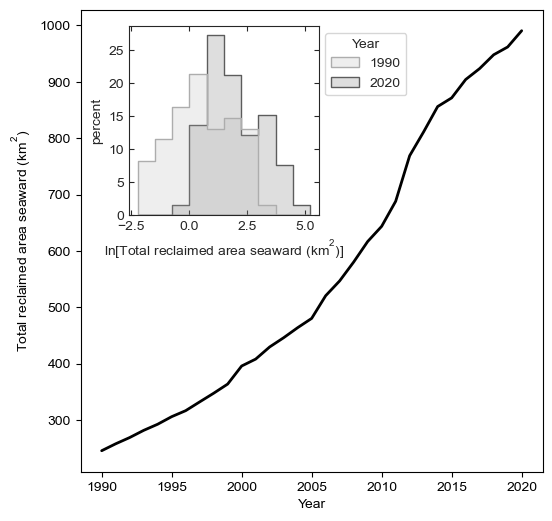

In [19]:
# Create plot for inset of Fig. 2 in Sengupta & Lazarus (2023)

f, ax = plt.subplots(figsize = (6, 6))

custom = {'font': 'Arial',
               'xtick.direction': 'in',
               'ytick.direction': 'in',
               'xtick.top': 'True',
               'ytick.right': 'True'}

sns.set_style('ticks', rc = custom)

# Main panel
sns.lineplot(data = Ry,
             x = "Year",
             y = "Reclaimed area (km^2, smoothed)",
            color = 'k',
            linewidth = 2)

plt.xlabel('Year')
plt.ylabel('Total reclaimed area seaward ($\mathregular{km^2}$)')


# Inset panel...
# axins = (ax, '30%', '30%', loc = 'upper left', borderpad = 3)
# axins = (ax, '30%', '30%', bbox_to_anchor = (0, 0.55), loc ='upper left', borderpad=1)
from matplotlib.transforms import blended_transform_factory  # noqa
transform = blended_transform_factory(f.transFigure, ax.transAxes)
axins = inset_axes(ax, '40%', '40%', bbox_to_anchor=(0.12, 0, 1, 1.025), bbox_transform=transform, loc=2, borderpad=2)

sns.histplot(data = comp,
             x  = np.log(comp['Reclaimed area (km^2, smoothed)']),
            hue = 'Year',
            stat = 'percent',
            element = 'step',
            fill = True,
            common_norm = False,
            palette = ['#adadad', '#5c5c5c'],
            alpha = 0.2)

plt.xlabel('ln[Total reclaimed area seaward ($\mathregular{km^2}$)]')
plt.ylabel('percent')
sns.move_legend(axins, loc = 'upper right', bbox_to_anchor = (1.5, 1))


# plt.legend(axins, frameon=False)

ax.set_box_aspect(1)
axins.set_box_aspect(1)

# plt.savefig('Fig2_doubleinset.png', dpi = 300)

## Exploring total seaward expansion, container volume (TEU), and sector shares in 2020

In [20]:
TEUS = pd.read_csv("Sengupta_Lazarus_REC_TEU_totals_v02.csv")

TEUS.head(3)

,Seaport,Country,Region,Total reclaimed area (km^2),Rank by total reclamation,"TEU (millions, 2020)",Rank by Lloyd's List (2020 data)
0,Shanghai,China,Asia,51.86,4,43.5034,1
1,Singapore,Singapore,Asia,58.86,2,36.8709,2
2,Ningbo-Zhoushan,China,Asia,28.67,10,28.7200,3


In [21]:
# Add China as its own region (alternative region grouping)

TEUS["Region (with China)"] = TEUS["Region"]

TEUS.loc[TEUS['Country'] == 'China', 'Region (with China)'] = 'China'

# tidy up...
R2 = TEUS.pop("Region (with China)")
TEUS.insert(3, "Region (with China)", R2)

TEUS.sort_values(by=["Rank by Lloyd's List (2020 data)"], inplace=True)

TEUS.head(10)

,Seaport,Country,Region,Region (with China),Total reclaimed area (km^2),Rank by total reclamation,"TEU (millions, 2020)",Rank by Lloyd's List (2020 data)
0,Shanghai,China,Asia,China,51.86,4,43.503400,1
1,Singapore,Singapore,Asia,Asia,58.86,2,36.870900,2
2,Ningbo-Zhoushan,China,Asia,China,28.67,10,28.720000,3
3,Shenzhen,China,Asia,China,33.87,7,26.550000,4
4,Guangzhou,China,Asia,China,32.91,8,23.505300,5
5,Qingdao,China,Asia,China,30.78,9,22.010000,6
6,Busan,South Korea,Asia,Asia,21.87,15,21.824000,7
7,Tianjin,China,Asia,China,183.78,1,18.353100,8
8,Hong Kong,China,Asia,China,5.07,32,17.953000,9
9,Rotterdam,Netherlands,Northern Europe,Northern Europe,24.76,13,14.349446,10


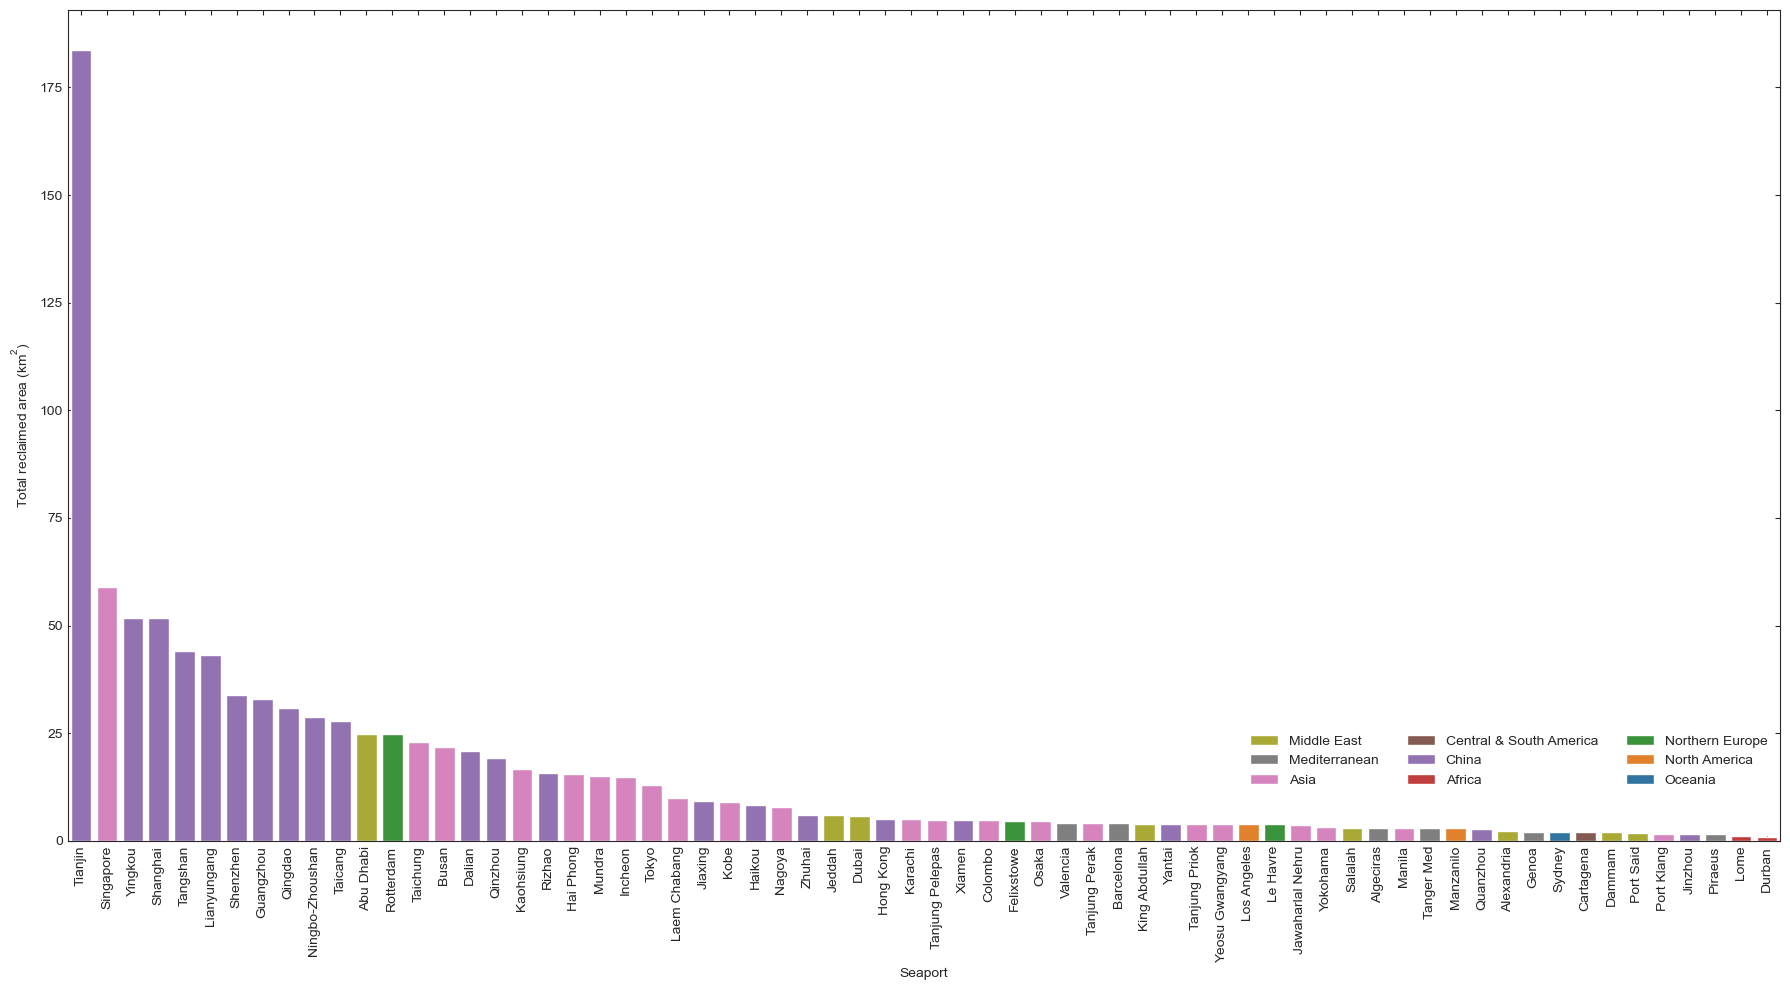

In [22]:
# Bar plot for Fig. 2 in Sengupta & Lazarus (2023)

f, ax = plt.subplots(figsize = (18, 10))

df = TEUS
df.sort_values(by=["Total reclaimed area (km^2)"], ascending=False, inplace=True)

matches = ['Middle East', 'Mediterranean', 'Asia', 'Central & South America',
          'China', 'Africa', 'Northern Europe', 'North America', 'Oceania']

custom = {'font': 'Arial',
               'xtick.direction': 'in',
               'ytick.direction': 'in',
               'xtick.top': 'True',
               'ytick.right': 'True'}

sns.set_style('ticks', rc = custom)


sns.barplot(data=df,
             x="Seaport",
             y="Total reclaimed area (km^2)",
            hue = "Region (with China)",
            palette = 'tab10_r',
            dodge = False,
            hue_order = matches
           )

plt.xticks(rotation=90)
plt.legend(loc = 'lower right', ncol = 3, frameon=False, bbox_to_anchor = (1, 0.05))

ax.set_ylabel('Total reclaimed area ($\mathregular{km^2}$)')


plt.tight_layout()

# plt.savefig('Bar-Total-Rec_V3.png', dpi = 300)

In [23]:
# Total TEU (millions) per region in 2020 (from LL 2020 data)
TEUregshare = TEUS.groupby("Region (with China)")["TEU (millions, 2020)"].sum()
TEUregshare

Region (with China)
Africa                       4.320672
Asia                       159.669307
Central & South America      3.127579
China                      237.675700
Mediterranean               27.201747
Middle East                 35.489214
North America               12.122032
Northern Europe             20.201446
Oceania                      2.395773
Name: TEU (millions, 2020), dtype: float64

In [24]:
# Total TEU (millions) from these 66 seaports in 2020 overall (from LL 2020 data)
TEUregshare = TEUS.groupby("Region (with China)")["TEU (millions, 2020)"].sum().sum()
TEUregshare

502.2034700000001

In [25]:
# Total TEU (millions) per region in 2020 (from LL 2020 data)
TEUregshare = TEUS.groupby("Region (with China)")["TEU (millions, 2020)"].sum()
(TEUregshare/632.2)*100 # as percentages of total TEUs across top 100 container ports (LL 2020 data)

Region (with China)
Africa                      0.683434
Asia                       25.256138
Central & South America     0.494714
China                      37.595017
Mediterranean               4.302712
Middle East                 5.613606
North America               1.917436
Northern Europe             3.195420
Oceania                     0.378958
Name: TEU (millions, 2020), dtype: float64

In [26]:
# Routine calculates annual percent seaward change at each seaport 
RTP = RECTIME.copy()
RTP = RTP.rename(columns={'Reclaimed area (km^2, smoothed)': 'Area'})

# calculate annual percent change in reclaimed area for each seaport and add as a new column:
RTP2 = pd.DataFrame(RTP
                    .assign(percent=(RTP
                    .groupby('Seaport')
                    .Area
                    .transform('pct_change')))
)


RTP2["percent"].clip(lower=0, inplace=True)
RTP2['percent'] = RTP2['percent'].fillna(0)
RTP2['percent'] = RTP2['percent']*100

RTP2.tail(3) # datframe check


,Year,Seaport,Country,Region,Region (with China),"Reclaimed area (km^2, raw)",Area,percent
2042,2020,Yingkou,China,Asia,China,51.87,51.87,1.745783
2044,2020,Yokohama,Japan,Asia,Asia,3.18,3.18,9.655172
2045,2020,Zhuhai,China,Asia,China,5.77,6.09,1.331115


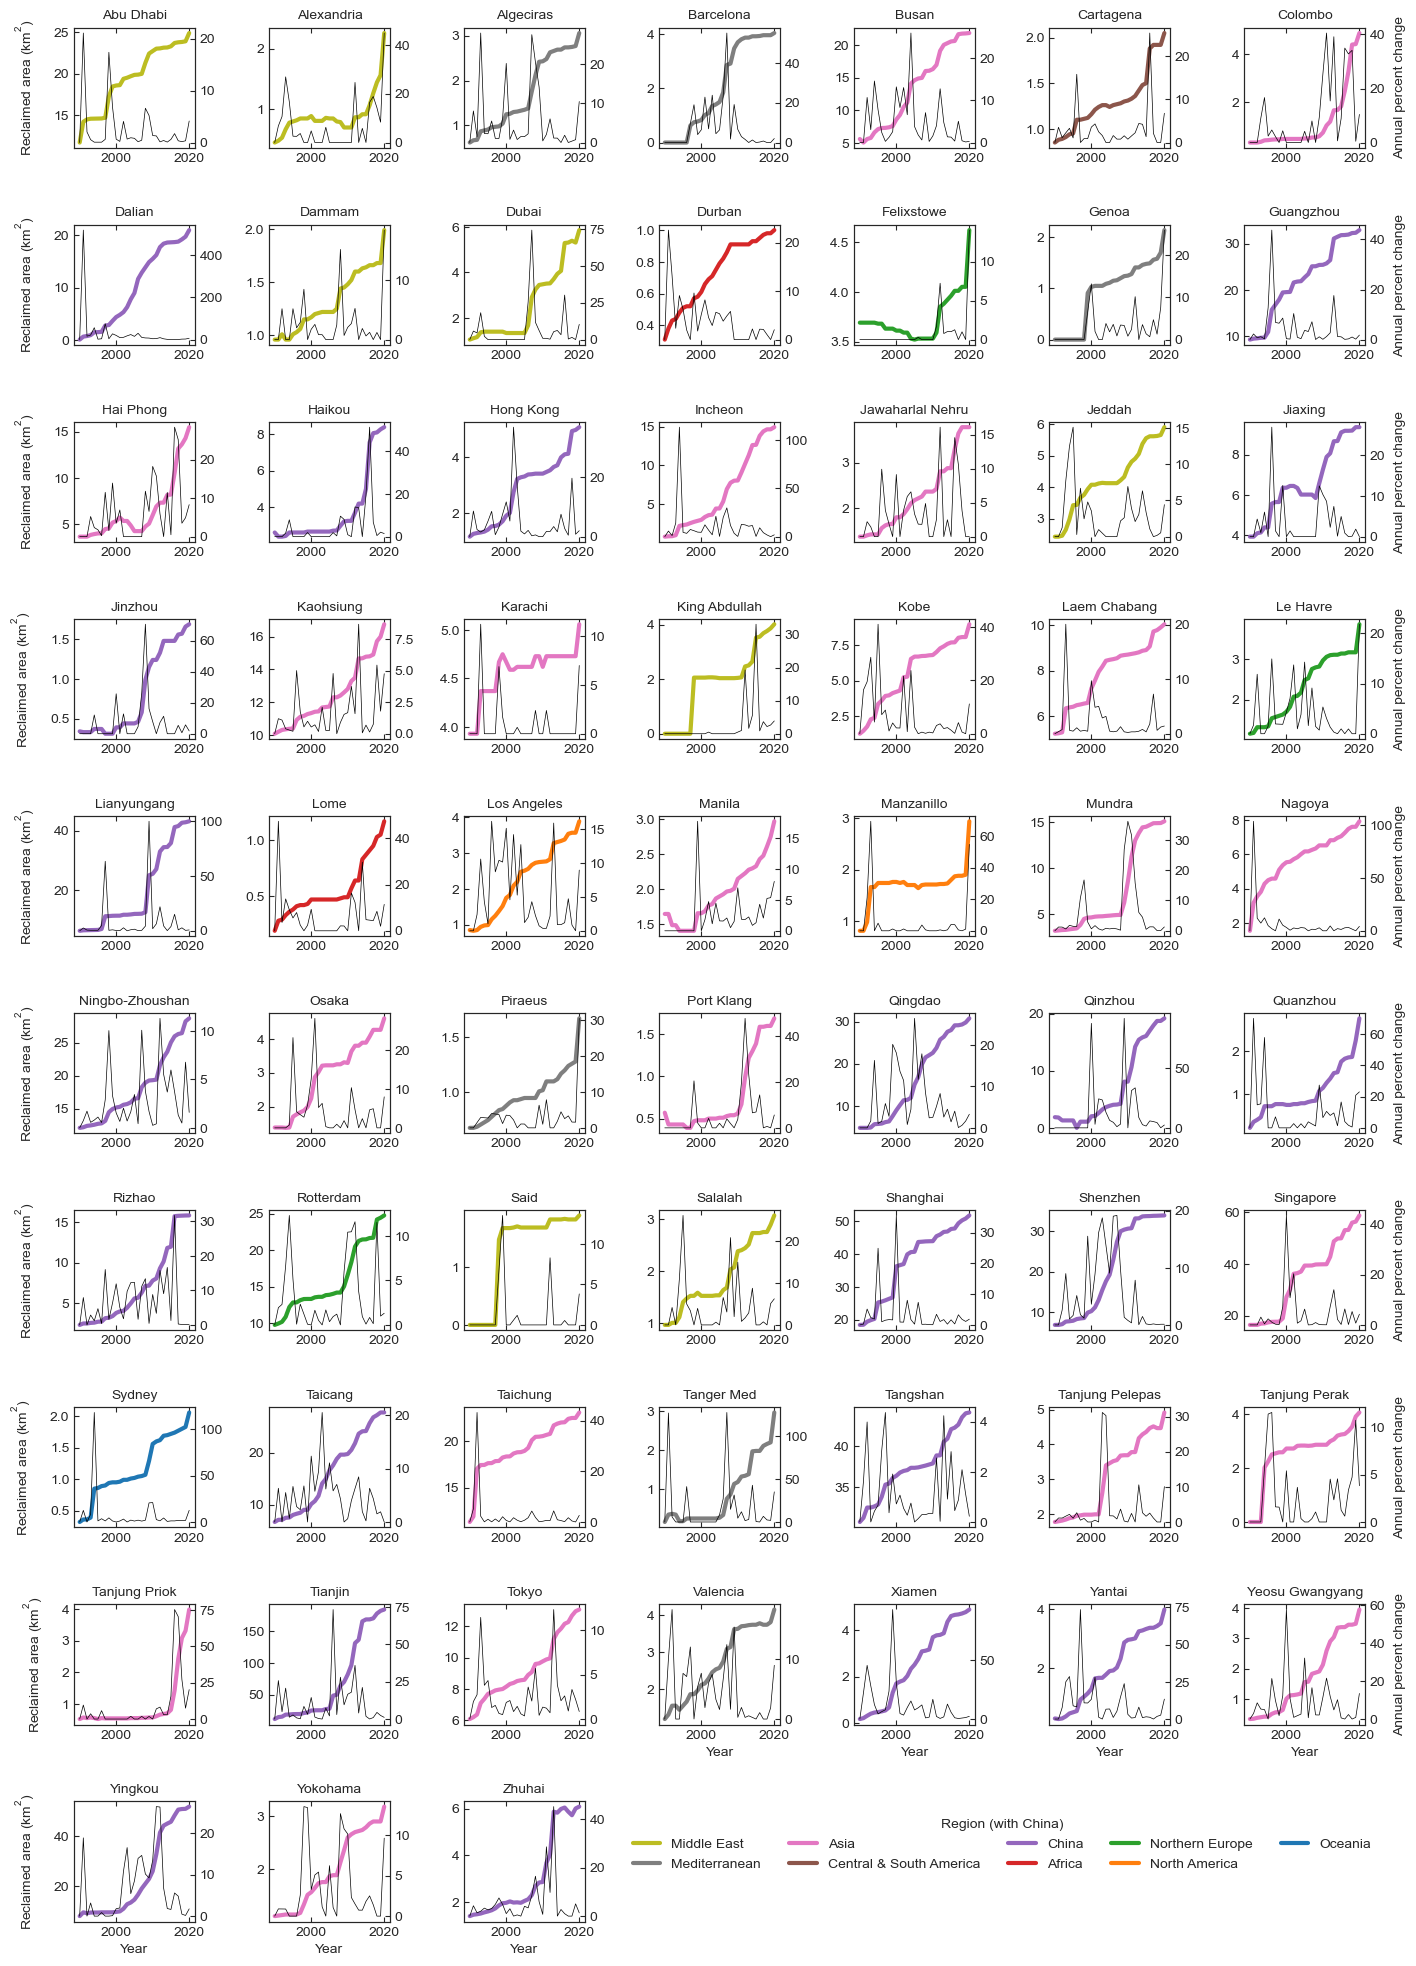

In [27]:
# Produce gridded subplots for Fig. 3 of Sengupta & Lazarus (2023)

df = RTP2

custom = {'font': 'Arial',
               'xtick.direction': 'in',
               'ytick.direction': 'in',
               'xtick.top': 'True',
               'ytick.right': 'True'}

sns.set_style('ticks', rc = custom)

def twin_lineplot(x,y,color,**kwargs):
    ax = plt.twinx()
    sns.lineplot(x=x,y=y,color=color,**kwargs, ax=ax)
    ax.set_box_aspect(1)
    ax.set_ylabel('')

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df,
                     col = "Seaport",
                     hue = "Region (with China)",
                     palette = "tab10_r",
                     col_wrap = 7,
                     height = 2,
                     sharey = False,
                     sharex = False,
                    despine = False,
                    aspect=1)

# Show the trajectory for each city
grid.map(plt.plot, "Year", "Area", linewidth = 3)

grid.map(twin_lineplot, "Year", 'percent', color='k', linewidth = 0.5, legend = False)

grid.set_axis_labels('Year', 'Reclaimed area ($\mathregular{km^2}$)')


# Adding y-axis label at the far right side of the grid
grid.set_ylabels("Reclaimed area ($\mathregular{km^2}$)", labelpad=20, va="center", position="right")


grid.set_titles(template = "{col_name}")


# Get the number of rows in the grid
num_rows = 7

# Add vertical text annotation to the last subplot of each row
for i, ax in enumerate(grid.axes.flat):
    if (i + 1) % num_rows == 0:
        ax.annotate('Annual percent change', xy=(1, 0.5), xytext=(21, 0),
                    xycoords='axes fraction', textcoords='offset points',
                    ha='left', va='center', rotation='vertical')


# grid.add_legend(loc='lower center', bbox_to_anchor=(0.32, -0.03), ncol=5)
grid.add_legend(loc='lower right', bbox_to_anchor=(0.65, 0.05), ncol=5)


# plt.savefig('Full_TS_v4.png', dpi = 300, bbox_inches='tight')

In [28]:
TEUS.head(3)

,Seaport,Country,Region,Region (with China),Total reclaimed area (km^2),Rank by total reclamation,"TEU (millions, 2020)",Rank by Lloyd's List (2020 data)
7,Tianjin,China,Asia,China,183.78,1,18.3531,8
1,Singapore,Singapore,Asia,Asia,58.86,2,36.8709,2
21,Yingkou,China,Asia,China,51.87,3,5.6500,27


In [29]:
TEUS = pd.read_csv("Sengupta_Lazarus_REC_TEU_totals_v02.csv")

# Add China as its own region (alternative region grouping)

TEUS["Region (with China)"] = TEUS["Region"]

TEUS.loc[TEUS['Country'] == 'China', 'Region (with China)'] = 'China'

# tidy up...
R2 = TEUS.pop("Region (with China)")
TEUS.insert(3, "Region (with China)", R2)

TEUS.sort_values(by=["Rank by Lloyd's List (2020 data)"], inplace=True)


df = TEUS
df.sort_values(by=["Seaport"], inplace=True)

df = df.rename(columns={"Rank by Lloyd's List (2020 data)": 'LL20 rank',
                       'Total reclaimed area (km^2)': 'Total reclaimed area'})

df.head(3)


,Seaport,Country,Region,Region (with China),Total reclaimed area,Rank by total reclamation,"TEU (millions, 2020)",LL20 rank
41,Abu Dhabi,UAE,Middle East,Middle East,24.87,12,3.220000,56
64,Alexandria,Egypt,Middle East,Middle East,2.26,56,1.677017,99
27,Algeciras,Spain,Mediterranean,Mediterranean,3.06,51,5.107873,33


Text(10, -10, 'b')

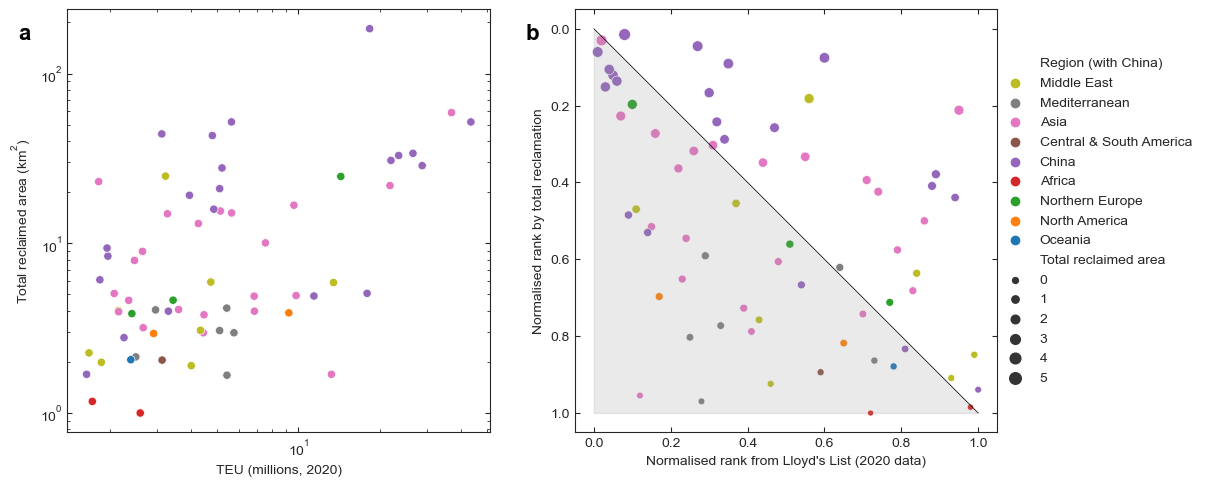

In [30]:
f, axes = plt.subplots(1, 2, figsize = (12, 6))

# PANEL A

sns.scatterplot(data = df,
                x = "TEU (millions, 2020)",
                y = "Total reclaimed area",
                hue = 'Region (with China)',
                palette = 'tab10_r',
                ax = axes[0],
                legend = False
               )
                                                            

sns.despine(right=False, top=False)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_box_aspect(1)

axes[0].set_ylabel("Total reclaimed area ($\mathregular{km^2}$)")
axes[0].set_xlabel("TEU (millions, 2020)")

# sns.move_legend(ax, loc = 'lower right')
# ax.legend(loc = 'center right', bbox_to_anchor = (1.46, 0.5), frameon=False)


# Panel B

sns.scatterplot(data = df,
                x = df["LL20 rank"]/np.max(df["LL20 rank"]),
                y = df['Rank by total reclamation']/np.max(df['Rank by total reclamation']),
                size = np.log(df['Total reclaimed area']),
                hue = 'Region (with China)',
                palette = 'tab10_r',
                ax = axes[1]
               )
                                                            

sns.despine(right=False, top=False)
axes[1].set_box_aspect(1)

axes[1].invert_yaxis()

# make reference line
plt.plot([0, 1], [0, 1], linewidth=0.5, color = 'k')
axes[1].fill_between([0, 1], [0, 1], 1, color = '0.6', alpha=0.2)

plt.ylabel("Normalised rank by total reclamation")
plt.xlabel("Normalised rank from Lloyd's List (2020 data)")

# sns.move_legend(ax, loc = 'lower right')
axes[1].legend(loc = 'center right', bbox_to_anchor = (1.49, 0.5), frameon=False)

axes[0].annotate('a', xy=(-0.15,1), xycoords="axes fraction",
                    xytext=(10,-10), textcoords="offset points",
                    ha="left", va="top",
             size = 16, color = 'black', weight = 'semibold')

axes[1].annotate('b', xy=(-0.15,1), xycoords="axes fraction",
                    xytext=(10,-10), textcoords="offset points",
                    ha="left", va="top",
             size = 16, color = 'black', weight = 'semibold')


# plt.savefig('Scatters_paired.png', dpi = 300, bbox_inches='tight')

In [31]:
# Number of seaports whose relative rank in terms of reclamation exceeds relative rank by container vol
x = df['LL20 rank']/np.max(df['LL20 rank'])
y = df['Rank by total reclamation']/np.max(df['Rank by total reclamation'])

R = x-y
sum(R>0) 


27

In [32]:
# print(sns.color_palette("tab10_r", 10).as_hex())

## Relating reclamation & TEU

In [33]:
# Import the seaward expansion vs trade volume over time dataset...
TRAJECTS = pd.read_csv("Sengupta_Lazarus_REC_TEU_2011_2020_v02.csv")

TRAJECTS.head(3) # check to confirm

,Year,Seaport,Country,Region,"Reclaimed area (km^2, raw)","Reclaimed area (km^2, smoothed)",TEU (millions)
0,2011,Tianjin,China,Asia,96.39,96.39,11.5
1,2011,Singapore,Singapore,Asia,39.09,39.93,29.9
2,2011,Shanghai,China,Asia,45.50,45.50,31.7


In [34]:
# Sort by seaport, then year
TRAJECTS.sort_values(by=['Seaport', 'Year'], inplace=True)

In [35]:
# Breakdown of regions in the TRAJECTS set
Treg = TRAJECTS.groupby("Region")["Seaport"].nunique()
Treg


Region
Asia                29
Mediterranean        6
Middle East          3
North America        1
Northern Europe      3
Oceania              1
Name: Seaport, dtype: int64

In [36]:
# Total number of seaports in TRAJECTS set
Treg = TRAJECTS.groupby("Region")["Seaport"].nunique().sum()
Treg


43

In [37]:
# Make China its own region (as above)...
TRAJECTS["Region (with China)"] = TRAJECTS["Region"]

TRAJECTS.loc[TRAJECTS['Country'] == 'China', 'Region (with China)'] = 'China'

# tidy up...
R2 = TRAJECTS.pop("Region (with China)")
TRAJECTS.insert(4, "Region (with China)", R2)

TRAJECTS.head(10)

,Year,Seaport,Country,Region,Region (with China),"Reclaimed area (km^2, raw)","Reclaimed area (km^2, smoothed)",TEU (millions)
27,2011,Algeciras,Spain,Mediterranean,Mediterranean,2.48,2.48,3.60
70,2012,Algeciras,Spain,Mediterranean,Mediterranean,2.66,2.63,4.11
113,2013,Algeciras,Spain,Mediterranean,Mediterranean,2.91,2.66,4.50
156,2014,Algeciras,Spain,Mediterranean,Mediterranean,2.69,2.69,4.55
199,2015,Algeciras,Spain,Mediterranean,Mediterranean,2.63,2.69,4.51
242,2016,Algeciras,Spain,Mediterranean,Mediterranean,2.75,2.74,4.76
285,2017,Algeciras,Spain,Mediterranean,Mediterranean,2.74,2.74,4.38
328,2018,Algeciras,Spain,Mediterranean,Mediterranean,2.69,2.75,4.77
371,2019,Algeciras,Spain,Mediterranean,Mediterranean,2.77,2.77,5.12
414,2020,Algeciras,Spain,Mediterranean,Mediterranean,3.06,3.06,5.11


In [38]:
print(sns.color_palette("tab10_r", 9).as_hex())

['#bcbd22', '#7f7f7f', '#e377c2', '#8c564b', '#9467bd', '#d62728', '#2ca02c', '#ff7f0e', '#1f77b4']


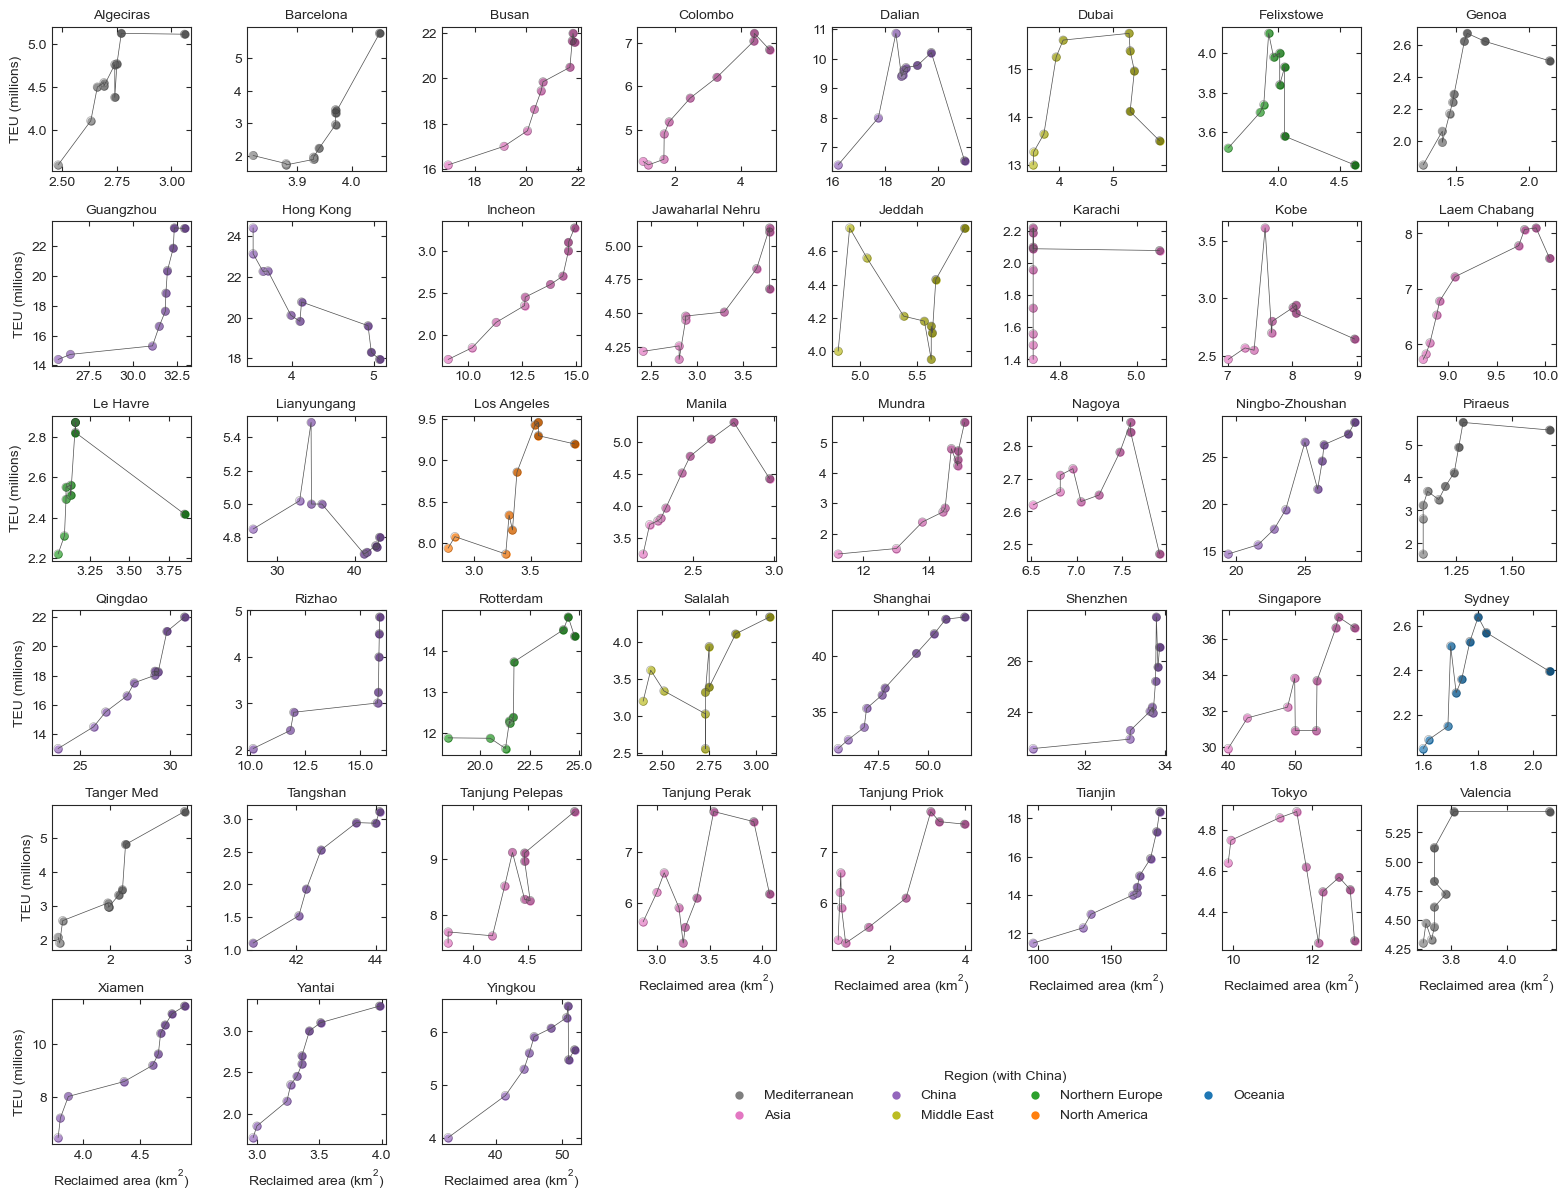

In [39]:
# Facetgrid arrangement:

df = TRAJECTS

# Above, color sequence goes = ['Middle East', 'Mediterranean', 'Asia', 'Central & South America',
# 'China', 'Africa', 'Northern Europe', 'North America', 'Oceania']
# 
# Here, subset goes: ['Mediterranean', 'Asia', 'China', 'Middle East', 'Northern Europe',
# 'North America', 'Oceania']...but colors need to match, so:

subset = ['#7f7f7f', '#e377c2', '#9467bd', '#bcbd22', '#2ca02c', '#ff7f0e', '#1f77b4']


custom = {'font': 'Arial',
               'xtick.direction': 'in',
               'ytick.direction': 'in',
               'xtick.top': 'True',
               'ytick.right': 'True'}

sns.set_style('ticks', rc = custom)

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df,
                     col = "Seaport",
                     hue = "Region (with China)",
#                      palette = "tab10_r",
                     palette = subset,
                     col_wrap = 8,
                     height = 2,
                     sharey = False,
                     sharex = False,
                    despine = False)


# Show the trajectory for each city
grid.map(plt.plot, "Reclaimed area (km^2, smoothed)", "TEU (millions)", linewidth = 0.5, color = '0.3')

grid.map(plt.scatter, "Reclaimed area (km^2, smoothed)", "TEU (millions)",
#                      cmap='tab10_r',
                     edgecolor ='0',
                     linewidth=0,
                     alpha = 1)

# grid.add_legend(loc='lower center', bbox_to_anchor=(0.28, -0.05), ncol=4)
grid.add_legend(loc='lower right', bbox_to_anchor=(0.6, 0.05), ncol=4)


grid.map_dataframe(sns.scatterplot,
                   "Reclaimed area (km^2, smoothed)",
                   "TEU (millions)",
                   hue = 'Year',
                   palette = 'gray_r',
                   edgecolor ='k',
                   linewidth=0.5,
                   alpha = 0.3
                  )

grid.set_axis_labels('Reclaimed area ($\mathregular{km^2}$)')
grid.set_titles(template = "{col_name}")


# plt.savefig('TRAJECTS_layered_v4.png', dpi = 300, bbox_inches='tight')